In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,SimpleRNN,Dense
import tensorflow_datasets as tfdt
import re
import string
import matplotlib.pyplot as plt

In [3]:
train_ds,val_ds,test_ds=tfdt.load('imdb_reviews',split=['train','test[:50%]','test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DUUU55_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DUUU55_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DUUU55_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for review,label in train_ds.take(10):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

In [6]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_tag = tf.strings.regex_replace(lowercase, r"<[^>]+>", "")
    output = tf.strings.regex_replace(no_tag, f"[{re.escape(string.punctuation)}]", "")

    return output

In [7]:
standardization(tf.constant("<u>In the movie? ,</u>"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie '>

In [8]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
BATCH_SIZE=64

In [9]:
vectorized_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [9]:
# length=[]
# words=[]

# for reviews,labels in train_ds.take(10):
#   for word in tf.strings.split(reviews,sep=""):
#     if word in words:
#       pass
#     else:
#       words.append(word)
# print(len(words))
# print(words)


In [10]:
training_data=train_ds.map(lambda x,y:x)
vectorized_layer.adapt(training_data)

In [11]:
len(vectorized_layer.get_vocabulary())

10000

In [12]:
def vectorizer(review,labels):
  return vectorized_layer(review),labels

In [13]:
training_data=train_ds.map(vectorizer)
val_data=val_ds.map(vectorizer)

In [14]:
for review,label in training_data.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [15]:
training_data=training_data.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
EMBEDDING_DIMS=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIMS),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
    ])

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [19]:
history=model.fit(training_data,validation_data=val_data,epochs=50)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.5083 - loss: 0.6963 - val_accuracy: 0.5002 - val_loss: 0.6964
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.5690 - loss: 0.6698 - val_accuracy: 0.5073 - val_loss: 0.7014
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.6144 - loss: 0.6003 - val_accuracy: 0.5261 - val_loss: 0.7159
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.6514 - loss: 0.5287 - val_accuracy: 0.5030 - val_loss: 0.7959
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.6595 - loss: 0.5005 - val_accuracy: 0.5029 - val_loss: 0.8343
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.6671 - loss: 0.4803 - val_accuracy: 0.5018 - val_loss: 0.8672
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.6791 - loss: 0.4742 - val_accuracy: 0.5049 - val_loss: 0.8991
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6736 - loss: 0.4774 - 

In [20]:
history.history

{'accuracy': [0.5047600269317627,
  0.5779200196266174,
  0.6212800145149231,
  0.6514400243759155,
  0.6581199765205383,
  0.6670399904251099,
  0.673799991607666,
  0.6717600226402283,
  0.6737599968910217,
  0.6847599744796753,
  0.6867600083351135,
  0.6946799755096436,
  0.685479998588562,
  0.6838399767875671,
  0.693560004234314,
  0.6794000267982483,
  0.6939600110054016,
  0.7008799910545349,
  0.7020400166511536,
  0.7060800194740295,
  0.703279972076416,
  0.7071999907493591,
  0.6576399803161621,
  0.6068800091743469,
  0.6255999803543091,
  0.6244400143623352,
  0.6212800145149231,
  0.6284400224685669,
  0.6354799866676331,
  0.6358399987220764,
  0.6330000162124634,
  0.6456000208854675,
  0.6586400270462036,
  0.6667600274085999,
  0.6742799878120422,
  0.6839200258255005,
  0.7042800188064575,
  0.7132400274276733,
  0.6969599723815918,
  0.711679995059967,
  0.7167199850082397,
  0.7290400266647339,
  0.7256399989128113,
  0.7210800051689148,
  0.7219200134277344,
  0

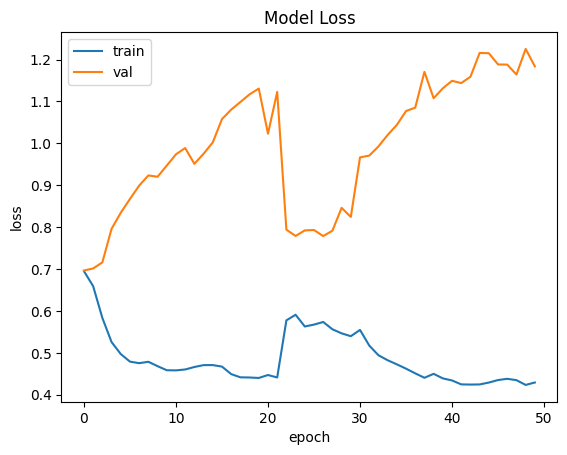

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","val"])

plt.show()

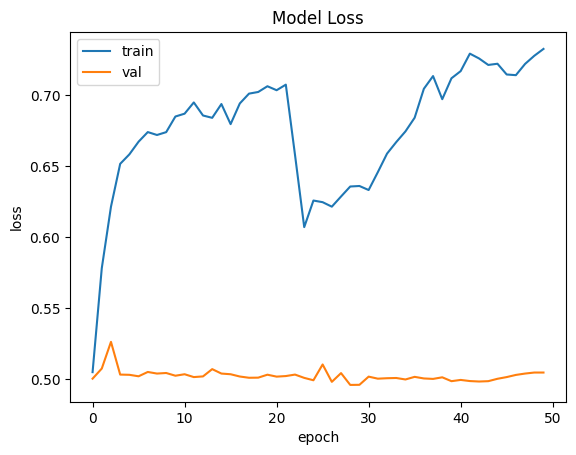

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","val"])
plt.show()